## Figures TFM

In [1]:
import pandas as pd
from Bio import SeqIO
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import gridspec
from scipy import stats
from tqdm.notebook import trange, tqdm
from statannot import add_stat_annotation
import math
import pickle
from matplotlib import patches
from matplotlib.lines import Line2D
from scipy import signal
from sklearn.metrics import roc_auc_score
from numpy.polynomial.polynomial import polyfit

In [2]:
#Load function to prepare tables
%run ../python_scripts/cptac_table.py

In [3]:
#Prepare CPTAC table
cptac_df = cptac_table()


Eliminate duplicated rna measures



Load NMD-score data and merge
Calculate rna fold-change
Load cdegron table and merge
Load last_aa table and merge
Load protein_positions_relative table and merge
Add creating cterm degron column
Add disrupting degron column


/workspace/users/msanchezg/python_scripts/cptac_table.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cptac_trunc_df['Protein_position1'] = cptac_trunc_df['Protein_position'].str.split('-',expand=True)[0]
/workspace/users/msanchezg/python_scripts/cptac_table.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cptac_trunc_df['Protein_position1'] = cptac_trunc_df['Protein_position1'].astype(int)
/workspace/users/msanchezg/python_scripts/cptac_table.py:216: SettingWithCopyWarning: 
A value is trying to

Add disrupting cterm degron column


In [4]:
#Prepare CCLE table
ccle_df = ccle_table()

Load CCLE dataset
Eliminate duplicated protein measures
Load NMD-scores data and merge


/workspace/users/msanchezg/python_scripts/cptac_table.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccle_mut_df['chrom'] = ccle_mut_df['Location'].str.split(':').str[0]
/workspace/users/msanchezg/python_scripts/cptac_table.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccle_mut_df['location2'] = ccle_mut_df['Location'].str.split(':').str[1]
/workspace/users/msanchezg/python_scripts/cptac_table.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Filter out CN high/low
Calculate fold-change rna
Load cdegron table and merge
Load last_aa table and merge
Load protein_positions_relative table and merge
Add creating cterm degron column
Add disrupting degron column
Add disrupting cterm degron column


## Figure 1: CPTAC and CCLE datasets, Stability Change, ARID1A

Text(0, -1.4, 'Total = 679')

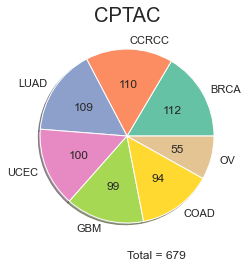

In [36]:
#Pie chart CPTAC

df = cptac_df[['sample','Dataset']]
df = df.drop_duplicates()
df = df.groupby('Dataset',as_index=False).count().sort_values('sample',ascending=False)
sizes = df['sample'].tolist()
labels = df['Dataset'].tolist()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct

c = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

plt.pie(sizes,labels=labels,autopct=make_autopct(sizes),shadow=True,colors=c)

plt.title('CPTAC',size=20)

total = 'Total = '+str(sum(sizes))
plt.text(0,-1.4,total,fontsize=12)

Text(0, -1.4, 'Total = 368')

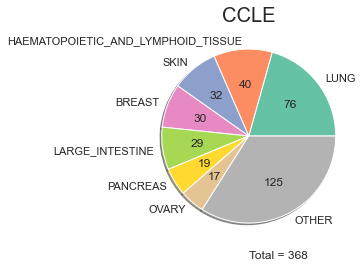

In [34]:
#Pie chart CCLE

df = ccle_df[['sample','sample_type']]
df = df.drop_duplicates()
df = df.groupby('sample_type',as_index=False).count().sort_values(by='sample',ascending = False)
df1 = df[df['sample']<15]
df2 = df[df['sample']>=15]
other = ['OTHER',sum(df1['sample'].tolist())]
other_series = pd.Series(other,index=df.columns)
df = df2.append(other_series,ignore_index=True)

sizes = df['sample'].tolist()
labels = df['sample_type'].tolist()

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct

c = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

plt.pie(sizes,labels=labels,autopct=make_autopct(sizes),shadow=True,colors=c)

plt.title('CCLE',size=20)

total = 'Total = '+str(sum(sizes))
plt.text(0,-1.4,total,fontsize=12)

In [42]:

def sc_table (df):
    '''Function to Stability_Change table for volcano plot'''
    
    mut_df = df[['gene','ID','Stability_Change']][(df['Phenotype']=='stop_gained')|(df['Phenotype']=='frameshift_variant')]
    mut_df = mut_df.drop_duplicates(subset='ID',keep='first')
    mut2_df = mut_df.groupby('gene',as_index=False).count()
    mut2_df = mut2_df[mut2_df['ID']>=10]
    mut2_df = mut2_df[['gene','ID']]
    mut2_df = mut2_df.rename(columns={'ID':'N_muts'})
    
    mut_gene_list = mut2_df['gene'].tolist()
    wt_df = df[['gene','ID','Stability_Change']][(df['gene'].isin(mut_gene_list))&(df['Phenotype']=='WT')]
    wt_df = wt_df.drop_duplicates(subset='ID',keep='first')
    mut3_df = mut_df.groupby('gene',as_index=False).median()
    wt2_df = wt_df.groupby('gene',as_index=False).median()
    mut3_df = mut3_df.rename(columns={'Stability_Change':'Stability_Change_mean_mut'})
    wt2_df = wt2_df.rename(columns={'Stability_Change':'Stability_Change_mean_wt'})
    df = pd.merge(wt2_df,mut3_df,how='left')
    df['Stability_Change_fc'] = df['Stability_Change_mean_wt'] - df['Stability_Change_mean_mut']
    df['Stability_Change_fc'] = df['Stability_Change_fc'].abs()
    df = pd.merge(df,mut2_df,how='left')
    
    # calculate AUC
    mut_df['Phenotype'] = 'Trunc'
    wt_df['Phenotype'] = 'WT'
    df1 = pd.concat([wt_df,mut_df],ignore_index=True)
    
    AUC_list=[]
    for gene in mut_gene_list:
        df2 = df1[df1['gene']==gene]
        probs = df2['Stability_Change']
        y = df2['Phenotype']
        auc = roc_auc_score(y, probs)
        AUC_list.append([gene,round(auc,3)])
        
    AUC_df = pd.DataFrame(AUC_list,columns=['gene','AUC_Stability_Change'])
    df = pd.merge(df,AUC_df,how='left')
    df['AUC_Stability_Change_inv'] = 1- df['AUC_Stability_Change']
    return df

In [81]:

def volcano_plot (df, xlim1,xlim2,ylim1,ylim2,sc_fc1,sc_fc2,auc1,auc2,title):
    '''Function to volcano plot'''
    
    x = df['AUC_Stability_Change_inv']
    y = df['Stability_Change_fc']
    sub_select = (df['Stability_Change_fc']>sc_fc1)|((df['Stability_Change_fc']>sc_fc2)&(df['AUC_Stability_Change_inv']<auc1))|(df['AUC_Stability_Change_inv']>auc2)
    t = df['gene'][sub_select]
    s = df['N_muts']
    
    col         = 'AUC_Stability_Change_inv'
    conditions  = [ df[col] <0.3, (df[col] <0.7) & (df[col]>0.3), df[col]>0.7 ]
    choices     = [ 'Destabilizing', 'Neutral', 'Stablizing' ]
    df['AUC'] = np.select(conditions, choices, default=np.nan)
    cols_dict = {'Destabilizing':'blue','Neutral':'grey','Stablizing':'red'}
    AUC = df['AUC'].values.tolist()
    cols = []
    for auc in AUC:
        col = cols_dict[auc]
        cols.append(col)
    
    sns.set_style(style='white')
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_title(title,fontsize=20)
    scatter = ax.scatter(x,y,s=s,c=cols)
    ax.set_xlim(xlim1,xlim2)
    ax.set_ylim(ylim1,ylim2)
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+(xlim2-xlim1)*0.015, point['y'], str(point['val']))
    x1 = df['AUC_Stability_Change_inv'][sub_select]
    y1 = df['Stability_Change_fc'][sub_select]
    label_point(x1, y1, t, plt.gca())
    ax.axvline(0.7,color='grey')
    ax.axvline(0.3,color='grey')
    ax.set_xlabel('AUC of ROC curve of Stability Change WT vs. Truncating')
    ax.set_ylabel('Stability Change fold-change WT vs. Mutant')
    handles, labels = scatter.legend_elements(prop="sizes",alpha=0.6,num=[10,20,50,100])
    ax.legend(handles,labels,title='Number of mutations',loc='upper right')

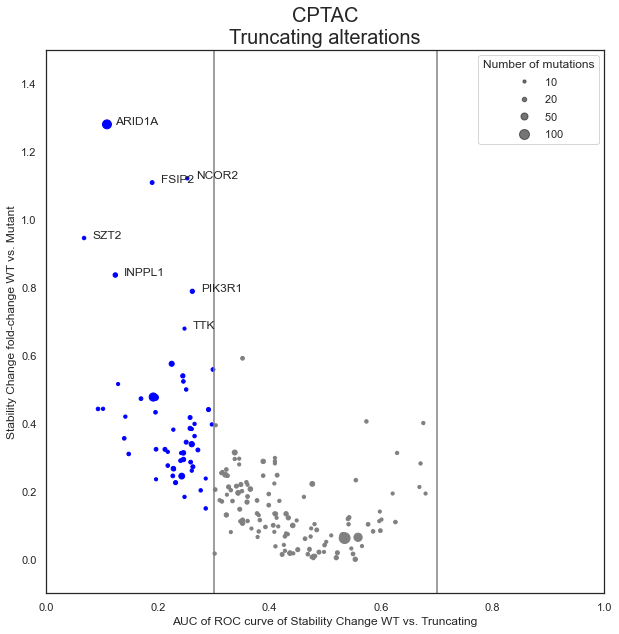

In [83]:
# Volcano plot AUC ROC (Stability change WT_vs_mut) vs Stability change fold-change, CPTAC
cptac_sc_df = sc_table(cptac_df)
xlim1 = 0
xlim2 = 1
ylim1 = -0.1
ylim2 = 1.5
sc_fc1 = 0.6
sc_fc2 = 0.6
auc1 = 0.15
auc2 = 0.7
volcano_plot(cptac_sc_df,xlim1,xlim2,ylim1,ylim2,sc_fc1,sc_fc2,auc1,auc2,'CPTAC\nTruncating alterations')

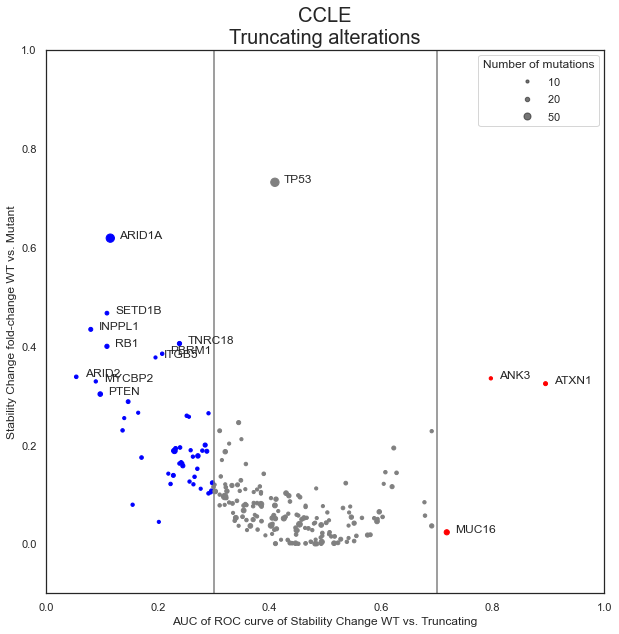

In [86]:
# Volcano plot AUC ROC (Stability change WT_vs_mut) vs Stability change fold-change, CCLE
ccle_sc_df = sc_table(ccle_df)
xlim1 = 0
xlim2 = 1
ylim1 = -0.1
ylim2 = 1
sc_fc1 = 0.6
sc_fc2 = 0.3
auc1 = 0.3
auc2 = 0.7
volcano_plot(ccle_sc_df,xlim1,xlim2,ylim1,ylim2,sc_fc1,sc_fc2,auc1,auc2,'CCLE\nTruncating alterations')

<ipython-input-80-69441573d1e0>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mutation_type'] = np.select(conditions, choices, default=np.nan)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Non_trunc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.932e-01 U_stat=1.492e+04
WT v.s. Trunc: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.461e-29 U_stat=4.211e+04


(<AxesSubplot:xlabel='Mutation_type', ylabel='Stability_Change'>,
  <statannot.StatResult.StatResult at 0x7f87693b7340>])

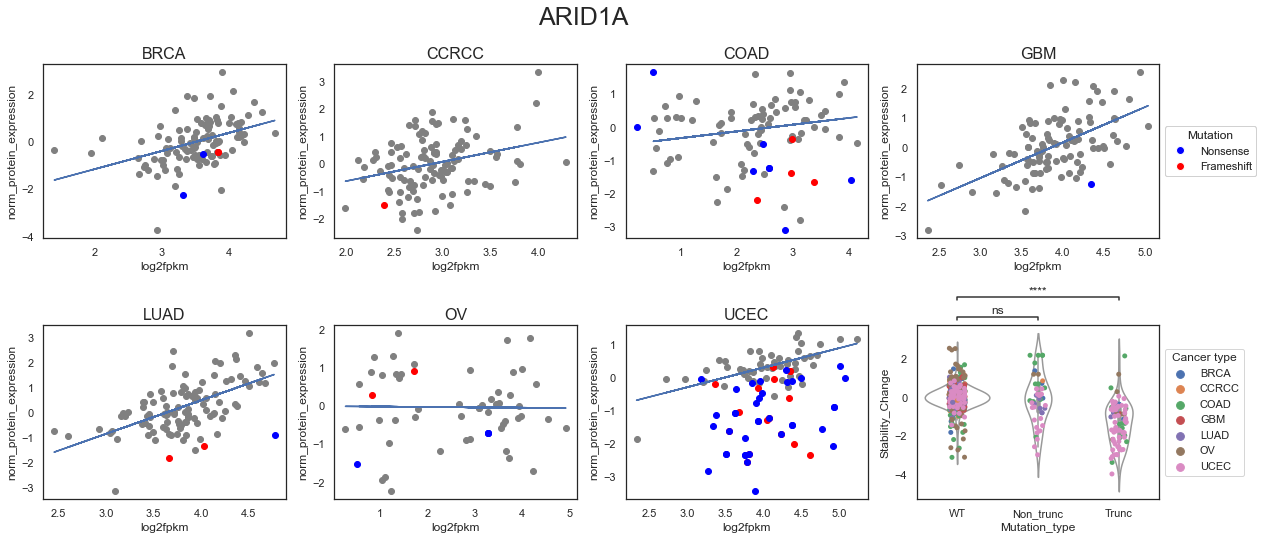

In [80]:
#Plot ARID1A mRNA_vs_Protein, Stability_Change by muation_type

sns.set_style(style='white')
fig,axs = plt.subplots(2,4)
fig.set_size_inches(20, 8)
axs = axs.ravel()
fig.suptitle('ARID1A', size=25)
fig.subplots_adjust(wspace=0.2, hspace=0.5)
datasets = cptac_df['Dataset'].drop_duplicates().tolist()

for i in range(len(datasets)):
    dataset = datasets[i]
    df = cptac_df[(cptac_df['gene']=='ARID1A')&(cptac_df['Dataset']==dataset)]
    x = df['log2fpkm'][df['Phenotype']=='WT']
    y = df['norm_protein_expression'][df['Phenotype']=='WT']
    x1 = df['log2fpkm'][df['Phenotype']=='stop_gained']
    x2 = df['log2fpkm'][df['Phenotype']=='frameshift_variant']
    y1 = df['norm_protein_expression'][df['Phenotype']=='stop_gained']
    y2 = df['norm_protein_expression'][df['Phenotype']=='frameshift_variant']
    axs[i].scatter(x,y,c='grey')
    axs[i].scatter(x1,y1,c='red')
    axs[i].scatter(x2,y2,c='blue')
    b, m = polyfit(x, y, 1)
    axs[i].plot(x, b + m * x, '-')
    axs[i].set_title(dataset, fontsize=16)
    axs[i].set_xlabel('log2fpkm')
    axs[i].set_ylabel('norm_protein_expression')
    
legend_cols_dict = [Line2D([0],[0],color='w',markerfacecolor='blue',marker='o',markersize=8,label='Nonsense'),
                       Line2D([0],[0],color='w',markerfacecolor='red',marker='o',markersize=8,label='Frameshift')]
legend1 = axs[3].legend(handles=legend_cols_dict,loc='center left',bbox_to_anchor=(1, 0.5),title='Mutation')
axs[3].add_artist(legend1)

df = cptac_df[(cptac_df['gene']=='ARID1A')]
col         = 'Phenotype'
conditions  = [ df[col] == 'WT', (df[col] == 'stop_gained') | (df[col]== 'frameshift_variant'), (df[col] != 'WT')|(df[col] != 'stop_gained')|(df[col] != 'frameshift_variant')]
choices     = [ "WT", 'Trunc', 'Non_trunc' ]
df['Mutation_type'] = np.select(conditions, choices, default=np.nan)
axs[7] = sns.violinplot(x='Mutation_type',y='Stability_Change',data=df,color='white')
axs[7] = sns.stripplot(x='Mutation_type',y='Stability_Change',data=df,hue='Dataset')
axs[7].legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Cancer type')

s = ['WT','Non_trunc','Trunc']
add_stat_annotation(axs[7], data=df, x='Mutation_type', y='Stability_Change', order=s,
                        box_pairs=[("WT", "Non_trunc"), ("WT", "Trunc")],
                        test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

## Figure S1: Stability Change vs. VAF CPTAC

In [56]:

def mult_scatterplot(df, genes):
    '''Function to scatterplot VAF_vs_Stability_Change'''
    
    df = df.drop_duplicates(subset='ID',keep='first')
    df = df[~df['AF_cancer'].isnull()]
    df = df[df['gene'].isin(genes)]
    
    fig,axs = plt.subplots(nrows=3,ncols=2)
    axs = axs.ravel()
    fig.set_size_inches(13, 8)
    fig.subplots_adjust(top=0.9, hspace=0.6,wspace=0.2)
    sns.set(style='white')
    
    x = 'AF_cancer'
    y = 'Stability_Change'

    for i in range(len(genes)):
        df1 = df[df['gene'] == genes[i]]
        title = genes[i]
        axs[i].set_title(title, size=20)
        axs[i].set_xlim(0,1)

        cols_dict = {'frameshift_variant':'firebrick','stop_gained':'cornflowerblue'}
        phenotype = df1['Phenotype'].values.tolist()
        cols = []
        for pheno in phenotype:
            col = cols_dict[pheno]
            cols.append(col)

        sns.regplot(x=x, y=y,data=df1,ax=axs[i])
        axs[i].scatter(x=x, y=y,data=df1,c=cols)
        
        axs[i].set_xlabel('VAF')

        xs = df1[x].values
        ys = df1["Stability_Change"].values

        pearson_coef_pval = stats.pearsonr(x=xs,y=ys)
        pearson_coef = round(pearson_coef_pval[0],4)
        pearson_pval = round(pearson_coef_pval[1],4)

        axs[i].text(.65, 0.9, 'Pearson coeff = '+str(pearson_coef),transform=axs[i].transAxes, fontsize=10)
        axs[i].text(.65, 0.8, 'Pearson pval = '+str(pearson_pval),transform=axs[i].transAxes, fontsize=10)

    legend_cols_dict = [Line2D([0],[0],color='w',markerfacecolor='cornflowerblue',marker='o',markersize=8,label='Nonsense'),
                       Line2D([0],[0],color='w',markerfacecolor='firebrick',marker='o',markersize=8,label='Frameshift')]
    legend1 = axs[1].legend(handles=legend_cols_dict,loc='upper right',bbox_to_anchor=(1, 1.6),title='Mutation')
    axs[1].add_artist(legend1)

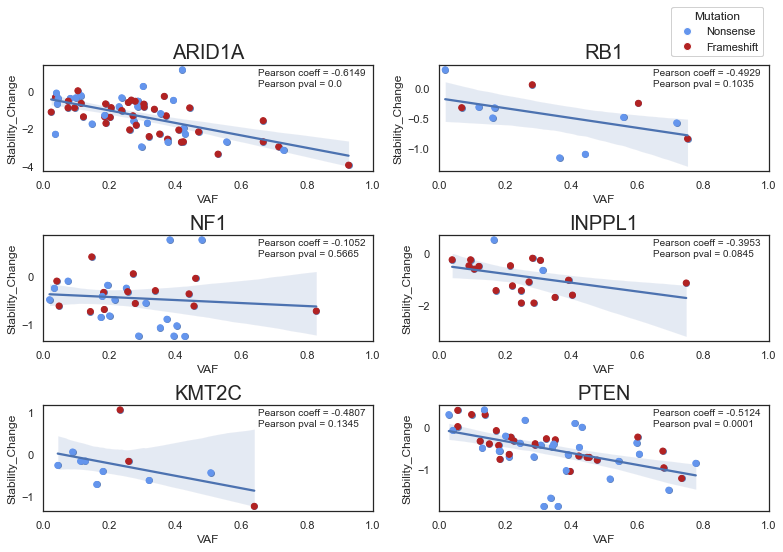

In [57]:
#Scatterplots VAF_vs_Stability_change

df = cptac_df[(cptac_df['Phenotype']=='stop_gained')|(cptac_df['Phenotype']=='frameshift_variant')]
genes = ['ARID1A','RB1','NF1','INPPL1','KMT2C','PTEN']
mult_scatterplot(df, genes)

## Figure 2: NMD-skipping/triggering CPTAC

In [18]:
def plots_wt_ns_fs (df,title,pad,size,y_var,ylim1,ylim2):
    '''Function to plot mRNA/Stability change by mutation type'''
    
    df.drop_duplicates(subset='ID',inplace=True,keep='first')
    sns.set(style='whitegrid')
    plt.figure(figsize=(5,3))
    plt.ylim([ylim1,ylim2])
    plt.title(title, size=20,pad=pad)

    x = "Phenotype"
    y = y_var
    
    c = {'WT':'#377eb8','':'white','synonymous_variant':'#4daf4a','missense_variant':'#ff7f00','stop_gained':'#e41a1c','frameshift_variant':'#984ea3'}  
    s = ['WT','synonymous_variant','missense_variant','stop_gained','frameshift_variant']
    t = ['','','','stop_gained','frameshift_variant']
    
    ax = sns.stripplot(x=x,y=y,data=df,jitter=True,alpha=0.6,size=size, order=t,palette=c)
    ax = sns.boxplot(x=x,y=y,data=df,width=0.5,saturation=0.7,fliersize=0.,linewidth=1, order=s,palette=c)
    
    for patch in ax.artists:
         r, g, b, a = patch.get_facecolor()
         patch.set_facecolor((r, g, b, .7))
        
    plt.xticks(np.arange(5), ['WT','Synonymous', 'Missense', 'Nonsense','Frameshift'])
    plt.xlabel('Mutation type')
    
    add_stat_annotation(ax, data=df, x=x, y=y, order=s,
                        box_pairs=[("WT", "missense_variant"), ("WT", "synonymous_variant"),("WT", "stop_gained"), ("WT", "frameshift_variant")],
                        test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.908e-01 U_stat=7.336e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.744e-02 U_stat=2.097e+11
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.196e-02 U_stat=2.716e+09
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.814e-01 U_stat=4.845e+09


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.193e-20 U_stat=7.555e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.031e-168 U_stat=2.240e+11
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.596e-14 U_stat=3.278e+09
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.383e-28 U_stat=5.745e+09


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.718e-07 U_stat=1.497e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.621e-49 U_stat=4.488e+10
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.467e-05 U_stat=6.537e+08
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.501e-08 U_stat=8.763e+08


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.908e-01 U_stat=7.336e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.744e-02 U_stat=2.097e+11
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.940e-86 U_stat=1.553e+10
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.455e-145 U_stat=2.269e+10


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.193e-20 U_stat=7.555e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.031e-168 U_stat=2.240e+11
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.563e-90 U_stat=1.559e+10
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.015e-101 U_stat=2.208e+10


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.718e-07 U_stat=1.497e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.621e-49 U_stat=4.488e+10
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.519e-34 U_stat=2.953e+09
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.464e-45 U_stat=2.843e+09


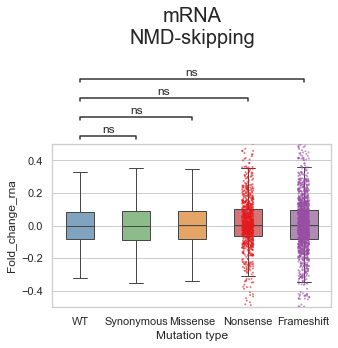

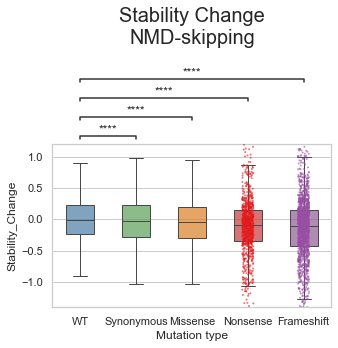

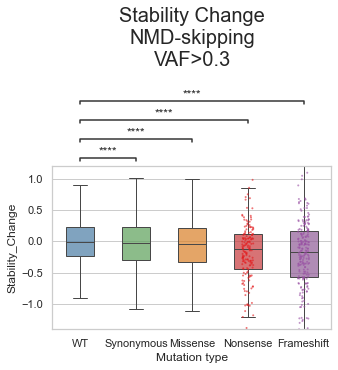

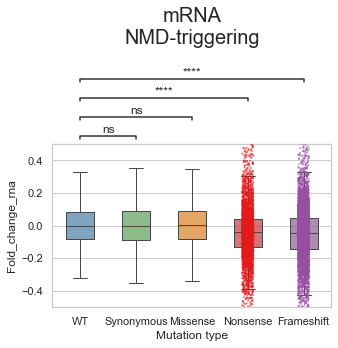

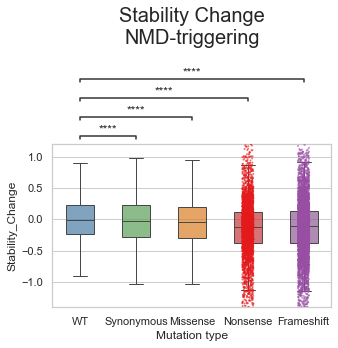

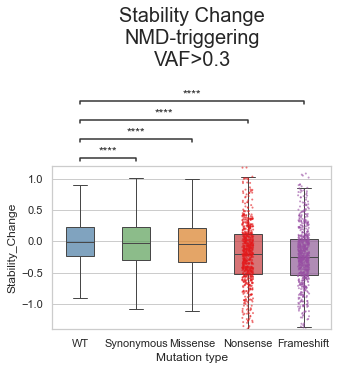

In [19]:
#mRNA/Stability Change by mutation type, CPTAC

df = cptac_df[(((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25))|((cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))|(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='missense_variant')|(cptac_df['Phenotype']=='synonymous_variant'))&(cptac_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'mRNA\nNMD-skipping',100,2,"Fold_change_rna",-0.5, 0.5)

df = cptac_df[(((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25))|((cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))|(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='missense_variant')|(cptac_df['Phenotype']=='synonymous_variant'))&(cptac_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'Stability Change\nNMD-skipping',100,2,"Stability_Change",-1.4, 1.2)

df = cptac_df[(((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25))|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))|(cptac_df['Phenotype']=='WT')|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='missense_variant')|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='synonymous_variant'))&(cptac_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'Stability Change\nNMD-skipping\nVAF>0.3',100,2,"Stability_Change",-1.4, 1.2)

df = cptac_df[(((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52))|((cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))|(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='missense_variant')|(cptac_df['Phenotype']=='synonymous_variant'))&(cptac_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'mRNA\nNMD-triggering',100,2,"Fold_change_rna",-0.5, 0.5)

df = cptac_df[(((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52))|((cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))|(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='missense_variant')|(cptac_df['Phenotype']=='synonymous_variant'))&(cptac_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'Stability Change\nNMD-triggering',100,2,"Stability_Change",-1.4, 1.2)

df = cptac_df[(((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52))|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))|(cptac_df['Phenotype']=='WT')|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='missense_variant')|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='synonymous_variant'))&(cptac_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'Stability Change\nNMD-triggering\nVAF>0.3',100,2,"Stability_Change",-1.4, 1.2)

## Figure S2: NMD skipping/triggering CCLE

<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.020e-47 U_stat=3.265e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.157e-194 U_stat=6.959e+10
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.786e-02 U_stat=7.003e+08
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.382e-08 U_stat=1.540e+09


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.538e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.755e-81 U_stat=8.005e+10
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.951e-16 U_stat=8.940e+08
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.827e-24 U_stat=1.984e+09


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.020e-47 U_stat=3.265e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.157e-194 U_stat=6.959e+10
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.742e-95 U_stat=3.295e+09
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.807e-91 U_stat=5.889e+09


<ipython-input-18-5174303c579e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. synonymous_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.538e+10
WT v.s. missense_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.755e-81 U_stat=8.005e+10
WT v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.565e-63 U_stat=3.280e+09
WT v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.761e-113 U_stat=6.144e+09


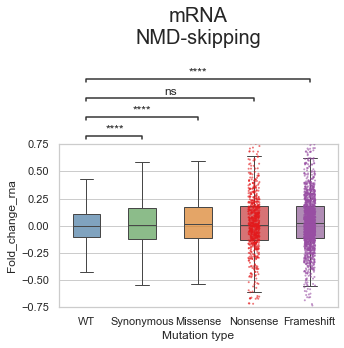

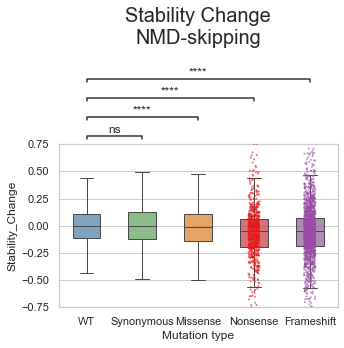

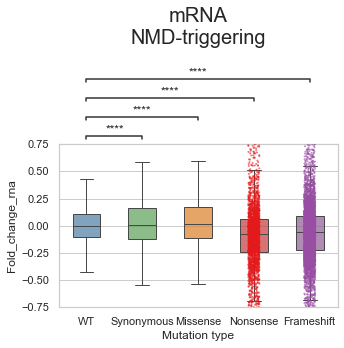

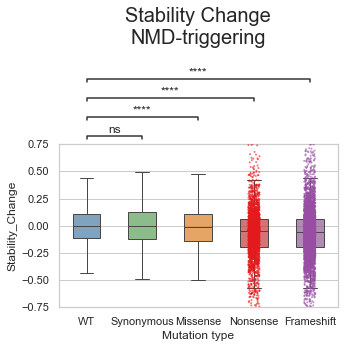

In [20]:
#mRNA/Stability Change by mutation type, CCLE

df = ccle_df[(((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']<0.25))|((ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']<0.25))|(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='missense_variant')|(ccle_df['Phenotype']=='synonymous_variant'))&(ccle_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'mRNA\nNMD-skipping',100,2,s,t,"Fold_change_rna",-0.75, 0.75)

df = ccle_df[(((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']<0.25))|((ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']<0.25))|(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='missense_variant')|(ccle_df['Phenotype']=='synonymous_variant'))&(ccle_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'Stability Change\nNMD-skipping',100,2,s,t,"Stability_Change",-0.75, 0.75)

df = ccle_df[(((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']>0.52))|((ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']>0.52))|(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='missense_variant')|(ccle_df['Phenotype']=='synonymous_variant'))&(ccle_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'mRNA\nNMD-triggering',100,2,s,t,"Fold_change_rna",-0.75, 0.75)

df = ccle_df[(((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']>0.52))|((ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']>0.52))|(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='missense_variant')|(ccle_df['Phenotype']=='synonymous_variant'))&(ccle_df['Altered_E3_Ligases']==False)]
plots_wt_ns_fs(df,'Stability Change\nNMD-triggering',100,2,s,t,"Stability_Change",-0.75, 0.75)

## Figure 3: C-terminal degrons

In [54]:
def plots_cterm_degron2 (df, title,pad,size,y_var,ylim1,ylim2):
    '''Function to Cterm degron False True'''
    
    df.drop_duplicates(subset='ID',inplace=True,keep='first')
    df['Creating_cterm_degron'] = ~df['Cterm_degron'].isnull()
    sns.set(style='whitegrid')
    plt.figure(figsize=(3,3))
    plt.ylim([ylim1,ylim2])
    plt.title(title, size=20,pad=pad)
    
    df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)
    s = ['False','True']
    
    x = "Creating_cterm_degron"
    y = y_var
    
    c = {'False':'#0571b0','True':'#ca0020'}
    
    ax = sns.stripplot(x=x,y=y,data=df,jitter=True,alpha=0.6,size=size, order=s,palette=c)
    ax = sns.boxplot(x=x,y=y,data=df,width=0.5,saturation=0.7,fliersize=0.,linewidth=1, order=s,palette=c)
    for patch in ax.artists:
         r, g, b, a = patch.get_facecolor()
         patch.set_facecolor((r, g, b, .7))
    add_stat_annotation(ax, data=df, x=x, y=y, order=s,
                        box_pairs=[('False', 'True')],
                        test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.689e-01 U_stat=5.678e+05


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.614e-01 U_stat=9.956e+06


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.911e-01 U_stat=7.280e+04


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.150e-02 U_stat=1.629e+06


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.236e-01 U_stat=2.333e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.211e-01 U_stat=3.526e+06


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


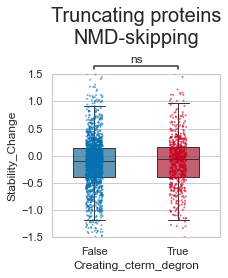

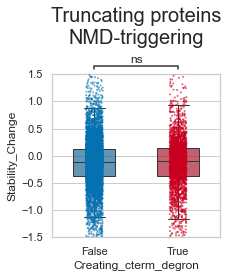

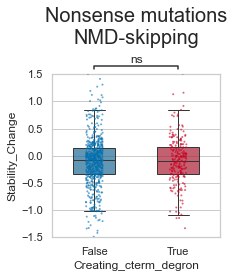

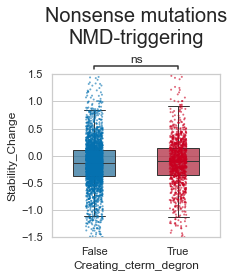

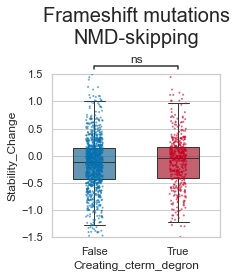

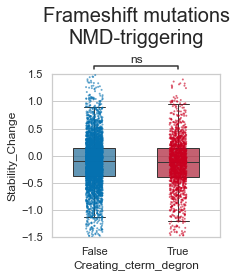

In [56]:
#Cterm degron False True CPTAC

df = cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Truncating proteins\nNMD-skipping',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Truncating proteins\nNMD-triggering',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Nonsense mutations\nNMD-skipping',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Nonsense mutations\nNMD-triggering',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Frameshift mutations\nNMD-skipping',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Frameshift mutations\nNMD-triggering',30,2, "Stability_Change",-1.5,1.5)

In [64]:
def plots_cterm_degron (df, title,pad,size,y_var,ylim1,ylim2):
    '''Function to plot stability change by Cterm degron'''
    
    sns.set(style='whitegrid')
    plt.figure(figsize=(5,3))
    plt.ylim([ylim1,ylim2])
    plt.title(title, size=20,pad=pad)
    
    df.drop_duplicates(['ID','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A'],inplace=True,keep='first')
    df = df[~df['Stability_Change'].isnull()]
    df = df.replace(np.nan, 'False', regex=True)
    
    s = ['False','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A']
    
    x = "Cterm_degron"
    y = y_var
    c = ['#0571b0','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

    ax = sns.stripplot(x=x,y=y,data=df,jitter=True,alpha=0.6,size=size, order=s,palette=c)
    ax = sns.boxplot(x=x,y=y,data=df,width=0.5,saturation=0.7,fliersize=0.,linewidth=1, order=s,palette=c)
    
    for patch in ax.artists:
         r, g, b, a = patch.get_facecolor()
         patch.set_facecolor((r, g, b, .7))
    add_stat_annotation(ax, data=df, x=x, y=y, order=s,
                    box_pairs=[('False', 'A'),],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

<ipython-input-57-eba7ffc99f77>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['ID','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A'],inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.437e-01 U_stat=7.378e+04


<ipython-input-57-eba7ffc99f77>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['ID','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A'],inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.104e-01 U_stat=1.246e+06


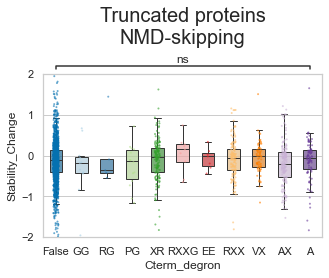

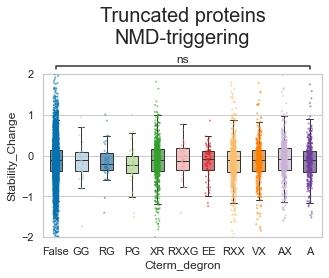

In [58]:
#Cterm_degrons CPTAC

df = cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron (df,'Truncated proteins\nNMD-skipping',30,2, "Stability_Change",-2,2)

df = cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron (df,'Truncated proteins\nNMD-triggering',30,2, "Stability_Change",-2,2)

In [ ]:
def ci95 (df):
    '''Function to calculate CI95'''
    ci95= []

    for i in df.index:
        last_aa, m, md, c, s = df.loc[i]
        ci95.append(1.96*s/math.sqrt(c))

    df['SC_ci95'] = ci95
    return df

In [ ]:
def datasets_ns_fs_df(df1,df2,nmd,mut,instance):
    '''Function to create df ns_fs betweeb CPTAC and CCLE datasets'''
    df1.drop_duplicates(['ID',instance], inplace=True,keep='first')
    df2.drop_duplicates(['ID',instance], inplace=True,keep='first')
    if nmd == False:
        mut1_df = df1[df1['Phenotype']==mut]
        mut2_df = df2[df2['Phenotype']==mut]
    elif nmd == 'skipping':
        mut1_df = df1[(df1['Phenotype']==mut)&(df1['nmd_score']<0.25)]
        mut2_df = df2[(df2['Phenotype']==mut)&(df2['nmd_score']<0.25)]
    elif nmd == 'triggering':
        mut1_df = df1[(df1['Phenotype']==mut)&(df1['nmd_score']>0.52)]
        mut2_df = df2[(df2['Phenotype']==mut)&(df2['nmd_score']>0.52)]

    median1_df = mut1_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    median1_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    median1_df = ci95(median1_df)

    median2_df = mut2_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    median2_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    median2_df = ci95(median2_df)

    median12_df = pd.merge(median1_df,median2_df, how='left',on=instance,suffixes=('_1','_2'))
    return median12_df

In [61]:
def scatterplots_nsfs (df, title,xlim1,xlim2,ylim1,ylim2,xlab,ylab,instance):
    '''Function to scatterplot'''
    
    sns.set(style='white')
    fig,ax = plt.subplots(figsize=(4,3))
    ax.scatter(x='SC_median_1',y='SC_median_2',data=df)
    sns.regplot(x='SC_median_1',y='SC_median_2',data=df)
    ax.set_title(title, fontsize=16,pad=20)
    ax.set_xlim(xlim1,xlim2)
    ax.set_ylim(ylim1,ylim2)

    # create the coordinates for the errorbars
    err_xs = []
    err_ys = []
    xerrs = df["SC_ci95_1"].values
    yerrs = df["SC_ci95_2"].values
    xs = df["SC_median_1"].values
    ys = df["SC_median_2"].values
    
    for x, y, xerr, yerr in zip(xs, ys, xerrs, yerrs):
        err_xs.append((x - xerr, x + xerr))
        err_ys.append((y - yerr, y + yerr))
    ax.errorbar(xs, ys, xerr=xerrs, yerr= yerrs, fmt='none',color="black",capsize=1.,elinewidth=0.1,capthick=0.1)

    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+(xlim2-xlim1)*0.015, point['y'], str(point['val']))
    
    label_point(df.SC_median_1, df.SC_median_2, df[instance], plt.gca()) 
    pearson_coef_pval = stats.pearsonr(x=xs,y=ys)
    pearson_coef = round(pearson_coef_pval[0],4)
    pearson_pval = round(pearson_coef_pval[1],4)
    pos1_coef = xlim2-(xlim2-xlim1)*0.6
    pos2_coef = ylim2-(ylim2-ylim1)*0.06
    pos1_pval = xlim2-(xlim2-xlim1)*0.6
    pos2_pval = ylim2-(ylim2-ylim1)*0.13
    ax.text(pos1_coef, pos2_coef, 'Pearson coeff = '+str(pearson_coef))
    ax.text(pos1_pval, pos2_pval, 'Pearson pval = '+str(pearson_pval))
    ax.set_xlabel(xlab,fontsize=10)
    ax.set_ylabel(ylab,fontsize=10)

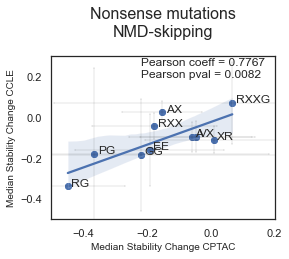

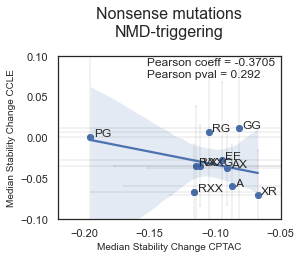

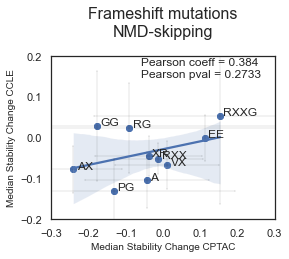

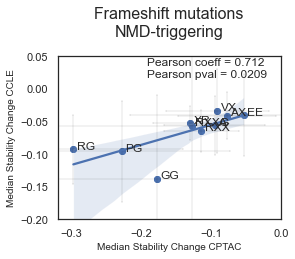

In [62]:
# Scatterplots Cterm_degron, CPTAC_vs_CCLE, ns and fs

df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='skipping',mut='stop_gained',instance='Cterm_degron')
scatterplots_nsfs(df, 'Nonsense mutations\nNMD-skipping',-0.5,0.2,-0.5,0.3,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='Cterm_degron')

df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='triggering',mut='stop_gained',instance='Cterm_degron')
scatterplots_nsfs(df, 'Nonsense mutations\nNMD-triggering',-0.22,-.05,-0.1,0.1,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='Cterm_degron')

df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='skipping',mut='frameshift_variant',instance='Cterm_degron')
scatterplots_nsfs(df, 'Frameshift mutations\nNMD-skipping',-0.3,0.3,-0.2,0.2,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='Cterm_degron')

df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='triggering',mut='frameshift_variant',instance='Cterm_degron')
scatterplots_nsfs(df, 'Frameshift mutations\nNMD-triggering',-0.32,0,-0.2,0.05,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='Cterm_degron')

In [76]:
def ns_fs_df(df,nmd,instance):
    '''Function to create df ns_fs'''
    
    df.drop_duplicates(subset=['ID',instance],inplace=True,keep='first')
    if nmd == False:
        ns_df = df[df['Phenotype']=='stop_gained']
        fs_df = df[df['Phenotype']=='frameshift_variant']
    elif nmd == 'skipping':
        ns_df = df[(df['Phenotype']=='stop_gained')&(df['nmd_score']<0.25)]
        fs_df = df[(df['Phenotype']=='frameshift_variant')&(df['nmd_score']<0.25)]
    elif nmd == 'triggering':
        ns_df = df[(df['Phenotype']=='stop_gained')&(df['nmd_score']>0.52)]
        fs_df = df[(df['Phenotype']=='frameshift_variant')&(df['nmd_score']>0.52)]

    ns_median_df = ns_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    ns_median_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    ns_median_df = ci95(ns_median_df)

    fs_median_df = fs_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    fs_median_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    fs_median_df = ci95(fs_median_df)

    ns_fs_median_df = pd.merge(ns_median_df,fs_median_df, how='left',on=instance,suffixes=('_1','_2'))
    return ns_fs_median_df

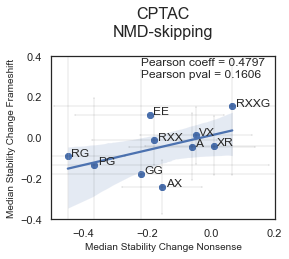

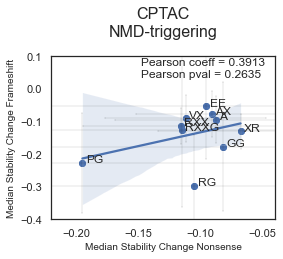

In [352]:
#Scatterplots Cterm_degron ns_vs_fs, CPTAC

df = ns_fs_df(cptac_df,nmd='skipping',instance='Cterm_degron')
scatterplots_nsfs(df,'CPTAC\nNMD-skipping',-0.5,0.2,-0.4,0.4,'Median Stability Change Nonsense','Median Stability Change Frameshift','Cterm_degron')

df = ns_fs_df(cptac_df,nmd='triggering',instance='Cterm_degron')
scatterplots_nsfs(df,'CPTAC\nNMD-triggering',-0.22,-.04,-0.4,0.1,'Median Stability Change Nonsense','Median Stability Change Frameshift','Cterm_degron')

df = ns_fs_degron_df(ccle_df,nmd='skipping')
scatterplots_nsfs(df,'CCLE\nNMD-skipping',-0.4,0.2,-0.25,0.2,'Median Stability Change Nonsense','Median Stability Change Frameshift','Cterm_degron')

df = ns_fs_degron_df(ccle_df,nmd='triggering')
scatterplots_nsfs(df,'CCLE\nNMD-triggering',-0.08,.025,-0.2,0.1,'Median Stability Change Nonsense','Median Stability Change Frameshift','Cterm_degron')

## Figure S3: Cterm degrons in CCLE

<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.452e-01 U_stat=6.419e+05


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)
<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_du

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.047e-01 U_stat=6.035e+06
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.316e-01 U_stat=5.986e+04


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)
<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_du

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.414e-01 U_stat=6.971e+05


<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)
<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.264e-01 U_stat=3.092e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.066e-01 U_stat=2.628e+06


<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


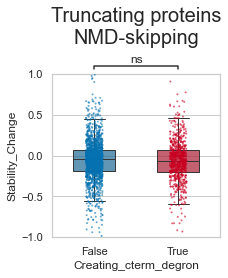

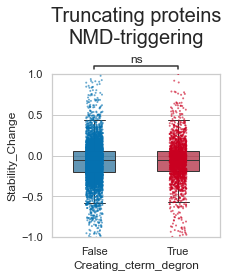

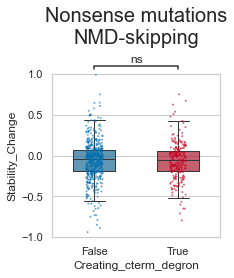

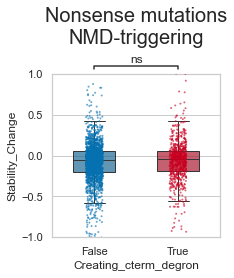

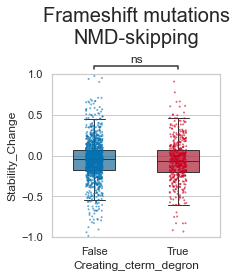

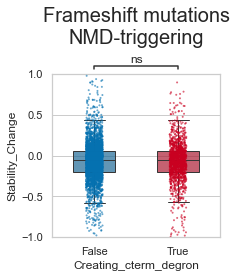

In [63]:
#Cterm degron False True, CCLE

df = ccle_df[((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']<0.25)|(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']<0.25))&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Truncating proteins\nNMD-skipping',30,2, "Stability_Change",-1,1)

df = ccle_df[((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']>0.52)|(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']>0.52))&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Truncating proteins\nNMD-triggering',30,2, "Stability_Change",-1,1)

df = ccle_df[(ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']<0.25)&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Nonsense mutations\nNMD-skipping',30,2, "Stability_Change",-1,1)

df = ccle_df[(ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']>0.52)&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Nonsense mutations\nNMD-triggering',30,2, "Stability_Change",-1,1)

df = ccle_df[(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']<0.25)&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Frameshift mutations\nNMD-skipping',30,2, "Stability_Change",-1,1)

df = ccle_df[(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']>0.52)&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Frameshift mutations\nNMD-triggering',30,2, "Stability_Change",-1,1)

<ipython-input-64-1a56b039fd94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['ID','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A'],inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.345e-02 U_stat=9.618e+04


<ipython-input-64-1a56b039fd94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['ID','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A'],inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.248e-01 U_stat=7.739e+05


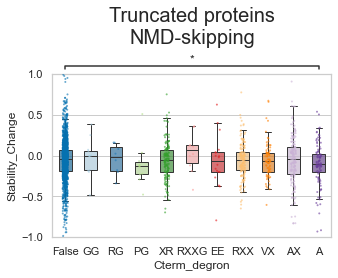

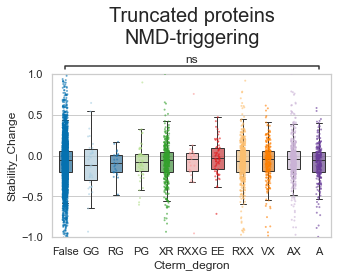

In [65]:
#Cterm degrons, CCLE

df = ccle_df[(((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']<0.25))|((ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']<0.25)))&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron (df,'Truncated proteins\nNMD-skipping',30,2, "Stability_Change",-1,1)

df = ccle_df[(((ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']>0.52))|((ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']>0.52)))&(ccle_df['Altered_E3_Ligases']==False)]
plots_cterm_degron (df,'Truncated proteins\nNMD-triggering',30,2, "Stability_Change",-1,1)

<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.435e-02 U_stat=1.295e+04


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.922e-01 U_stat=1.949e+05


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.752e-01 U_stat=2.303e+03


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.529e-02 U_stat=4.929e+04


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.598e-01 U_stat=4.356e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.222e-02 U_stat=4.838e+04


<ipython-input-54-15b84f8d6a61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-54-15b84f8d6a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Creating_cterm_degron'] = df['Creating_cterm_degron'].astype(str)


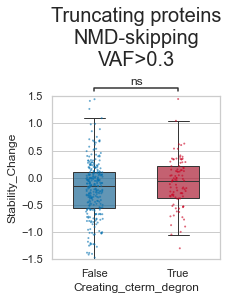

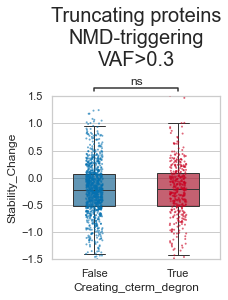

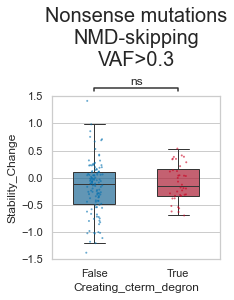

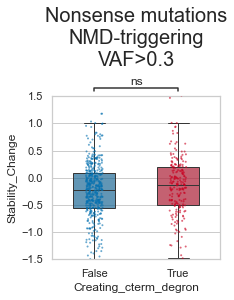

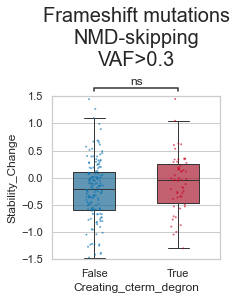

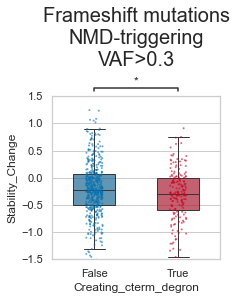

In [66]:
#Cterm degron False True, CPTAC VAF>0.3
df = cptac_df[((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Truncating proteins\nNMD-skipping\nVAF>0.3',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Truncating proteins\nNMD-triggering\nVAF>0.3',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Nonsense mutations\nNMD-skipping\nVAF>0.3',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Nonsense mutations\nNMD-triggering\nVAF>0.3',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Frameshift mutations\nNMD-skipping\nVAF>0.3',30,2, "Stability_Change",-1.5,1.5)

df = cptac_df[(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52)&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron2 (df,'Frameshift mutations\nNMD-triggering\nVAF>0.3',30,2, "Stability_Change",-1.5,1.5)

<ipython-input-64-1a56b039fd94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['ID','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A'],inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.064e-01 U_stat=2.205e+03


<ipython-input-64-1a56b039fd94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['ID','GG', 'RG', 'PG', 'XR', 'RXXG', 'EE', 'RXX', 'VX', 'AX', 'A'],inplace=True,keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. A: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.355e-02 U_stat=1.681e+04


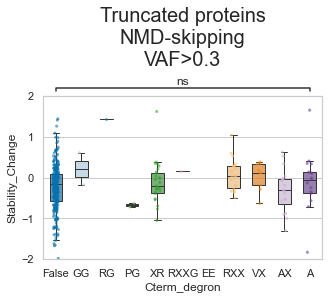

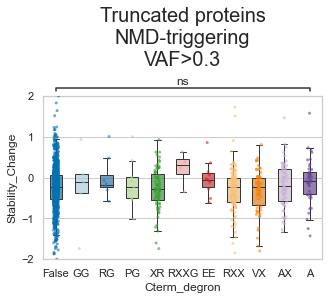

In [68]:
#Cterm degrons CPTAC VAF>0.3
df = cptac_df[((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron (df,'Truncated proteins\nNMD-skipping\nVAF>0.3',30,3, "Stability_Change",-2,2)

df = cptac_df[((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)|(cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))&(cptac_df['Altered_E3_Ligases']==False)]
plots_cterm_degron (df,'Truncated proteins\nNMD-triggering\nVAF>0.3',30,3, "Stability_Change",-2,2)

## Figure 4: Last amino acid analysis

In [78]:
def plots_last_aa (df,title, y_var,ylim1,ylim2):
    '''Function last_aa, ns+fs'''
    
    df.drop_duplicates(subset='ID',inplace=True,keep='first')
    sns.set(style='whitegrid')
    plt.figure(figsize=(7,3))
    plt.ylim([ylim1,ylim2])
    plt.title(title,size=16)

    x = "last_aa"
    y = y_var
    s=['A','C','D','E','F','G','H','I','K','Q','L','M','N','P','R','S','T','V','W','Y']
    c = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
    
    ax = sns.stripplot(x=x,y=y,data=df,jitter=True,alpha=0.6,size=2, order=s,palette=c)
    ax = sns.boxplot(x=x,y=y,data=df,width=0.5,fliersize=0.,linewidth=1, order=s,palette=c)
    for patch in ax.artists:
     r, g, b, a = patch.get_facecolor()
     patch.set_facecolor((r, g, b, .7))

<ipython-input-78-41c4c2c172f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-78-41c4c2c172f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


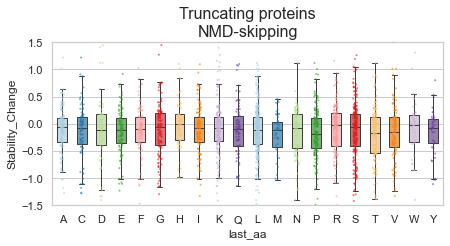

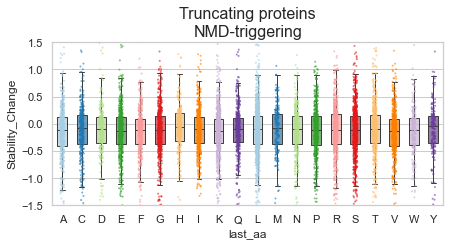

In [79]:
#last_aa, truncating

df= cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))&(cptac_df['Altered_E3_Ligases']==False)]
plots_last_aa(df, 'Truncating proteins\nNMD-skipping',"Stability_Change",-1.5,1.5)

df= cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))&(cptac_df['Altered_E3_Ligases']==False)]
plots_last_aa(df, 'Truncating proteins\nNMD-triggering',"Stability_Change",-1.5,1.5)

In [11]:
def plots2_last_aa (df,title, y_var,ylim1,ylim2):
    '''Function for last_aa ns_vs_fs'''
    df.drop_duplicates(subset='ID',inplace=True,keep='first')
    sns.set(style='whitegrid')
    plt.figure(figsize=(10,3))
    plt.ylim([ylim1,ylim2])
    plt.title(title,size=16)

    x = "last_aa"
    y = y_var
    s = ['A','C','D','E','F','G','H','I','K','Q','L','M','N','P','R','S','T','V','W','Y']
    t = ['stop_gained','frameshift_variant']
    c = {'stop_gained':'#0571b0','frameshift_variant':'#ca0020'}
    ax = sns.stripplot(x=x,y=y,data=df,jitter=True,alpha=0.6,size=2 ,order=s,hue="Phenotype",hue_order=t,dodge=True,palette=c)
    ax = sns.boxplot(x=x,y=y,data=df,width=0.5,fliersize=0.,linewidth=1,order=s,hue="Phenotype",hue_order=t,palette=c)
    for patch in ax.artists:
     r, g, b, a = patch.get_facecolor()
     patch.set_facecolor((r, g, b, .3))
    plt.legend(bbox_to_anchor=(0.75, 1.4), loc=2, borderaxespad=0.)

<ipython-input-13-1713dcb4eafc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')
<ipython-input-13-1713dcb4eafc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True,keep='first')


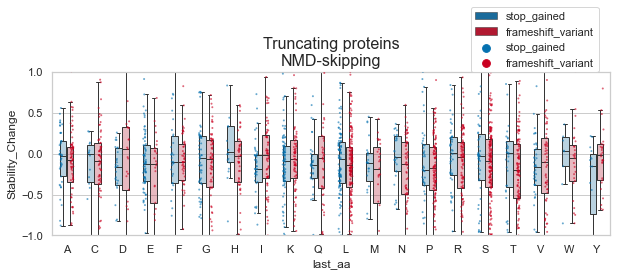

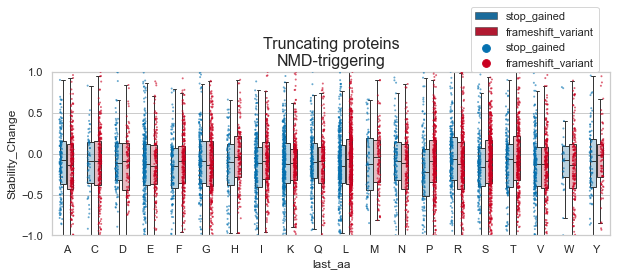

In [13]:
#Last_aa ns_vs_fs
df= cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))&(cptac_df['Altered_E3_Ligases']==False)]
plots2_last_aa(df,'Truncating proteins\nNMD-skipping', "Stability_Change",-1,1)

df= cptac_df[((cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))&(cptac_df['Altered_E3_Ligases']==False)]
plots2_last_aa(df,'Truncating proteins\nNMD-triggering', "Stability_Change",-1,1)

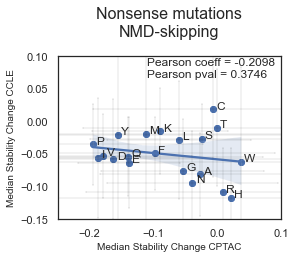

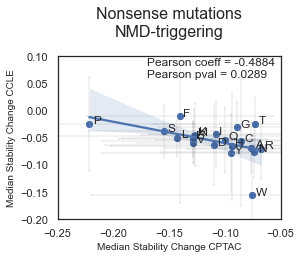

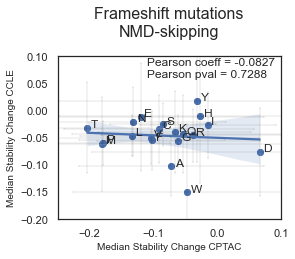

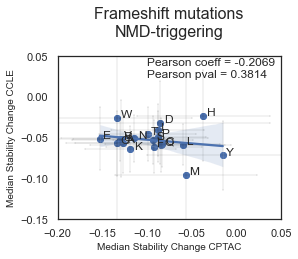

In [75]:
#Scatterplots last_aa, CPTAC_vs_CCLE, ns, fs
df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='skipping',mut='stop_gained',instance='last_aa')
scatterplots_nsfs(df, 'Nonsense mutations\nNMD-skipping',-0.25,0.1,-0.15,0.1,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='triggering',mut='stop_gained',instance='last_aa')
scatterplots_nsfs(df, 'Nonsense mutations\nNMD-triggering',-0.25,-.05,-0.2,0.1,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='skipping',mut='frameshift_variant',instance='last_aa')
scatterplots_nsfs(df, 'Frameshift mutations\nNMD-skipping',-0.25,0.1,-0.2,0.1,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

df = datasets_ns_fs_df(cptac_df,ccle_df,nmd='triggering',mut='frameshift_variant',instance='last_aa')
scatterplots_nsfs(df, 'Frameshift mutations\nNMD-triggering',-0.2,.05,-0.15,0.05,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

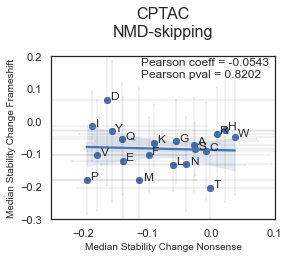

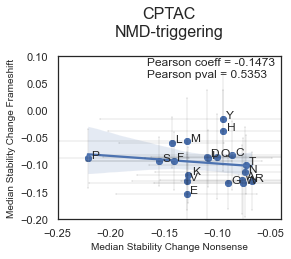

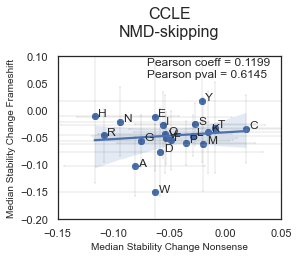

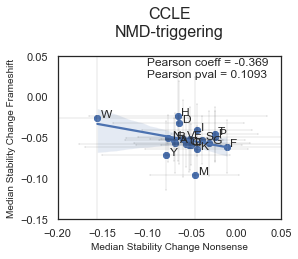

In [77]:
#Scatterplot last_aa, ns_vs_fs, CPTAC/CCLE
df = ns_fs_df(cptac_df,nmd='skipping',instance='last_aa')
scatterplots_nsfs(df,'CPTAC\nNMD-skipping',-0.25,0.1,-0.3,0.2,'Median Stability Change Nonsense','Median Stability Change Frameshift','last_aa')

df = ns_fs_df(cptac_df,nmd='triggering',instance='last_aa')
scatterplots_nsfs(df,'CPTAC\nNMD-triggering',-0.25,-.04,-0.2,0.1,'Median Stability Change Nonsense','Median Stability Change Frameshift','last_aa')

df = ns_fs_df(ccle_df,nmd='skipping',instance='last_aa')
scatterplots_nsfs(df,'CCLE\nNMD-skipping',-0.15,0.05,-0.2,0.1,'Median Stability Change Nonsense','Median Stability Change Frameshift','last_aa')

df = ns_fs_df(ccle_df,nmd='triggering',instance='last_aa')
scatterplots_nsfs(df,'CCLE\nNMD-triggering',-0.2,0.05,-0.15,0.05,'Median Stability Change Nonsense','Median Stability Change Frameshift','last_aa')

## Figure S4: Correlation analysis in CPTAC VAF>0.3

In [72]:
def datasets_ns_fs_VAF_df(df1,df2,nmd,mut,instance):
    '''Function to create df ns_vs_fs, VAF>0.3'''
    
    df1.drop_duplicates(['ID',instance], inplace=True,keep='first')
    df2.drop_duplicates(['ID',instance], inplace=True,keep='first')
    if nmd == False:
        mut1_df = df1[(df1['Phenotype']==mut)&(df1['AF_cancer']>0.3)]
        mut2_df = df2[(df2['Phenotype']==mut)]
    elif nmd == 'skipping':
        mut1_df = df1[(df1['Phenotype']==mut)&(df1['nmd_score']<0.25)&(df1['AF_cancer']>0.3)]
        mut2_df = df2[(df2['Phenotype']==mut)&(df2['nmd_score']<0.25)]
    elif nmd == 'triggering':
        mut1_df = df1[(df1['Phenotype']==mut)&(df1['nmd_score']>0.52)&(df1['AF_cancer']>0.3)]
        mut2_df = df2[(df2['Phenotype']==mut)&(df2['nmd_score']>0.52)]

    median1_df = mut1_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    median1_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    median1_df = ci95(median1_df)

    median2_df = mut2_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    median2_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    median2_df = ci95(median2_df)

    median12_df = pd.merge(median1_df,median2_df, how='left',on=instance,suffixes=('_1','_2'))
    return median12_df

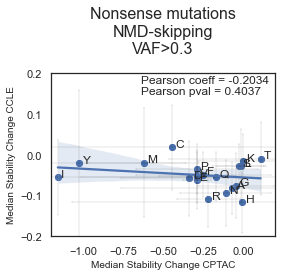

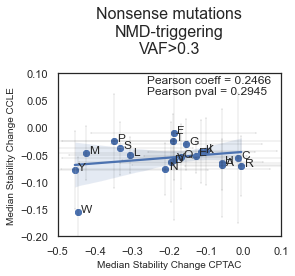

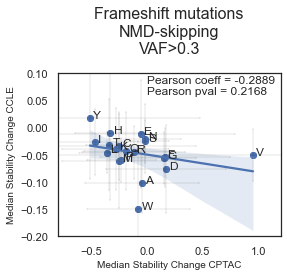

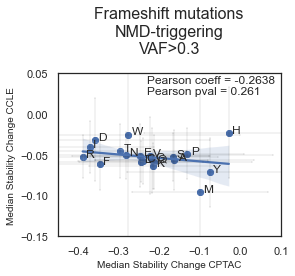

In [73]:
#Scatterplot last_aa, CPTAC(VAF>0.3) vs CCLE
df = datasets_ns_fs_VAF_df(cptac_df,ccle_df,nmd='skipping',mut='stop_gained',instance='last_aa')
scatterplots_nsfs(df, 'Nonsense mutations\nNMD-skipping\nVAF>0.3',-1.2,0.2,-0.2,0.2,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

df = datasets_ns_fs_VAF_df(cptac_df,ccle_df,nmd='triggering',mut='stop_gained',instance='last_aa')
scatterplots_nsfs(df, 'Nonsense mutations\nNMD-triggering\nVAF>0.3',-0.5,.1,-0.2,0.1,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

df = datasets_ns_fs_VAF_df(cptac_df,ccle_df,nmd='skipping',mut='frameshift_variant',instance='last_aa')
scatterplots_nsfs(df, 'Frameshift mutations\nNMD-skipping\nVAF>0.3',-0.8,1.2,-0.2,0.1,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

df = datasets_ns_fs_VAF_df(cptac_df,ccle_df,nmd='triggering',mut='frameshift_variant',instance='last_aa')
scatterplots_nsfs(df, 'Frameshift mutations\nNMD-triggering\nVAF>0.3',-0.45,0.1,-0.15,0.05,'Median Stability Change CPTAC','Median Stability Change CCLE', instance='last_aa')

In [367]:
def ns_fs_VAF_df(df,nmd,instance):
    '''Function to create df ns_fs'''
    
    df.drop_duplicates(subset=['ID',instance],inplace=True,keep='first')
    if nmd == False:
        ns_df = df[(df['Phenotype']=='stop_gained')&(df['AF_cancer']>0.3)]
        fs_df = df[df['Phenotype']=='frameshift_variant']
    elif nmd == 'skipping':
        ns_df = df[(df['Phenotype']=='stop_gained')&(df['nmd_score']<0.25)&(df['AF_cancer']>0.3)]
        fs_df = df[(df['Phenotype']=='frameshift_variant')&(df['nmd_score']<0.25)&(df['AF_cancer']>0.3)]
    elif nmd == 'triggering':
        ns_df = df[(df['Phenotype']=='stop_gained')&(df['nmd_score']>0.52)&(df['AF_cancer']>0.3)]
        fs_df = df[(df['Phenotype']=='frameshift_variant')&(df['nmd_score']>0.52)&(df['AF_cancer']>0.3)]

    ns_median_df = ns_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    ns_median_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    ns_median_df = ci95(ns_median_df)

    fs_median_df = fs_df[[instance,'Stability_Change']].groupby(instance,as_index=False).agg({'Stability_Change':['mean','median','count','std']})
    fs_median_df.columns = [instance,'SC_mean','SC_median','SC_count','SC_sd']

    fs_median_df = ci95(fs_median_df)

    ns_fs_median_df = pd.merge(ns_median_df,fs_median_df, how='left',on=instance,suffixes=('_1','_2'))
    return ns_fs_median_df

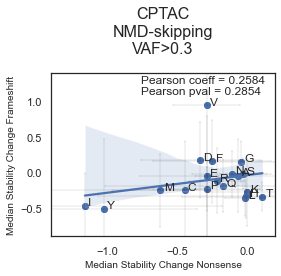

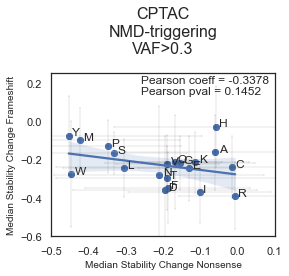

In [380]:
#Scatterplot last_aa, ns vs fs, CPTAC VAF>0.3
df = ns_fs_VAF_df(cptac_df,nmd='skipping',instance='last_aa')
scatterplots_nsfs(df,'CPTAC\nNMD-skipping\nVAF>0.3',-1.4,0.2,-0.9,1.4,'Median Stability Change Nonsense','Median Stability Change Frameshift','last_aa')

df = ns_fs_VAF_df(cptac_df,nmd='triggering',instance='last_aa')
scatterplots_nsfs(df,'CPTAC\nNMD-triggering\nVAF>0.3',-0.5,0.1,-0.6,0.25,'Median Stability Change Nonsense','Median Stability Change Frameshift','last_aa')

## Figure 5: Relative mutation position

In [6]:
def rel_mut_pos_plot (df,title,y_var,size,ylim1,ylim2):
    '''Function to plot relative mutation positions'''
    
    df.drop_duplicates(subset='ID',inplace=True, keep='first')
    sns.set(style='whitegrid')
    plt.figure(figsize=(4,3))

    s = ['WT','Q1','Q2','Q3','Q4']
    t = ['','Q1','Q2','Q3','Q4']

    x = 'Protein_position_relative'
    y = y_var

    p = {'WT':'#0571b0','':'white','Q1':'#fdbe85','Q2':'#fd8d3c','Q3':'#e6550d','Q4':'#a63603'}
    
    ax = sns.stripplot(x=x,y=y,data=df,order=t,size=size,palette=p)
    ax = sns.boxplot(x=x,y=y,data=df,order=s,palette=p,fliersize=0)
    
    for patch in ax.artists:
     r, g, b, a = patch.get_facecolor()
     patch.set_facecolor((r, g, b, .7))

    ax.set_ylim([ylim1, ylim2])
    ax.set_title(title,size=20,pad=100)
    add_stat_annotation(ax, data=df, x=x, y=y, order=s,
                        box_pairs=[('WT', 'Q1'),('Q1', 'Q2'),('Q1', 'Q3'),('Q1', 'Q4')],
                        test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

<ipython-input-7-a7d4ff34b228>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True, keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.034e-14 U_stat=1.439e+09
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.271e-01 U_stat=3.922e+04
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.200e-02 U_stat=5.721e+04
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.327e-02 U_stat=2.322e+05


<ipython-input-7-a7d4ff34b228>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True, keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.741e-36 U_stat=7.779e+09
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.126e+06
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.180e+06
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.005e+06


<ipython-input-7-a7d4ff34b228>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True, keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.995e-06 U_stat=4.828e+08
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.279e-01 U_stat=4.268e+03
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.270e-01 U_stat=6.620e+03
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.383e-01 U_stat=2.900e+04


<ipython-input-7-a7d4ff34b228>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True, keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.323e-16 U_stat=3.261e+09
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.593e+05
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.301e+05
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.579e+05


<ipython-input-7-a7d4ff34b228>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True, keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.028e-10 U_stat=9.557e+08
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.757e+04
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.600e-01 U_stat=2.489e+04
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.483e-01 U_stat=9.660e+04


<ipython-input-7-a7d4ff34b228>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ID',inplace=True, keep='first')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.595e-21 U_stat=4.519e+09
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.040e+06
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.113e+06
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.686e+05


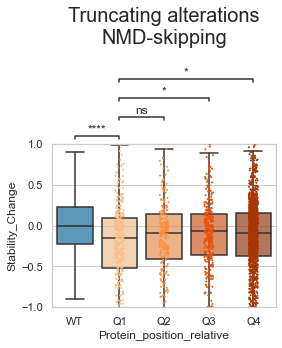

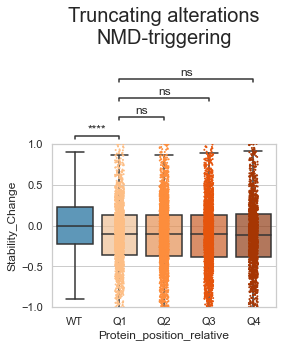

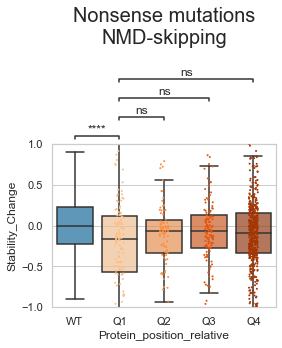

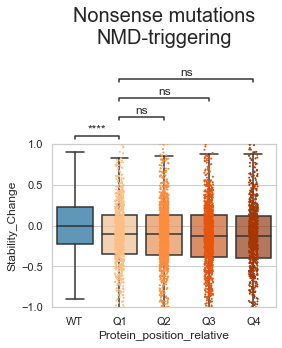

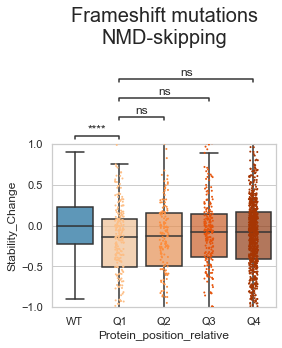

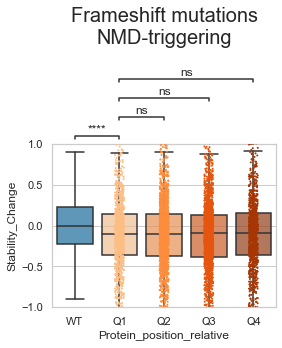

In [7]:
#Relative mutation position, CPTAC
df = cptac_df[(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25)]
rel_mut_pos_plot(df,'Truncating alterations\nNMD-skipping','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52)]
rel_mut_pos_plot(df,'Truncating alterations\nNMD-triggering','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25)]
rel_mut_pos_plot(df,'Nonsense mutations\nNMD-skipping','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52)]
rel_mut_pos_plot(df,'Nonsense mutations\nNMD-triggering','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25)]
rel_mut_pos_plot(df,'Frameshift mutations\nNMD-skipping','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52)]
rel_mut_pos_plot (df,'Frameshift mutations\nNMD-triggering','Stability_Change',2,-1,1)

In [90]:
def rel_mut_pos_plot2(df,title,y_var,size,ylim1,ylim2):
    '''Function to plot relative mutation positions by mutation type'''
    df.drop_duplicates(subset='ID',inplace=True,keep='first')
    sns.set(style='whitegrid')
    plt.figure(figsize=(4,3))
    s = ['synonymous_variant','missense_variant','stop_gained','frameshift_variant']
    t = ['','','stop_gained','frameshift_variant']
    x = 'Phenotype'
    y = y_var
    
    c = {'WT':'#4daf4a','':'white','synonymous_variant':'#984ea3','missense_variant':'#ff7f00','stop_gained':'#377eb8','frameshift_variant':'#e41a1c'}  
    c = {'WT':'#377eb8','':'white','synonymous_variant':'#4daf4a','missense_variant':'#ff7f00','stop_gained':'#e41a1c','frameshift_variant':'#984ea3'}  
    
    ax = sns.stripplot(x=x,y=y,data=df,size=size,order=t,palette=c)
    ax = sns.boxplot(x=x,y=y,data=df,order=s,palette=c,fliersize=0)
    
    for patch in ax.artists:
     r, g, b, a = patch.get_facecolor()
     patch.set_facecolor((r, g, b, .7))
        
    plt.xticks(np.arange(4), ['Synonymous', 'Missense', 'Nonsense','Frameshift'])
    plt.xlabel('Mutation type')
        
    ax.set_ylim([ylim1, ylim2])
    ax.set_title(title,size=20,pad=100)
    add_stat_annotation(ax, data=df, x=x, y=y, order=s,
                        box_pairs=[('synonymous_variant', 'stop_gained'),('synonymous_variant', 'frameshift_variant'),
                                   ('missense_variant', 'stop_gained'),('missense_variant', 'frameshift_variant')],
                        test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

missense_variant v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.946e-04 U_stat=1.100e+06
synonymous_variant v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.909e-04 U_stat=3.855e+05
missense_variant v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.839e-06 U_stat=2.169e+06
synonymous_variant v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.051e-06 U_stat=7.613e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

missense_variant v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.434e-01 U_stat

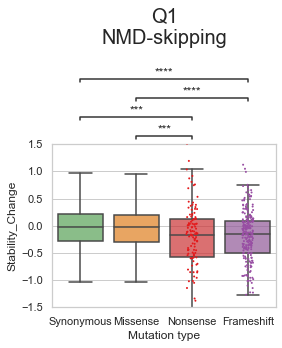

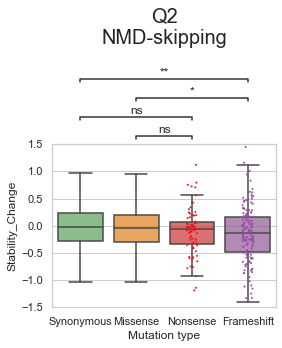

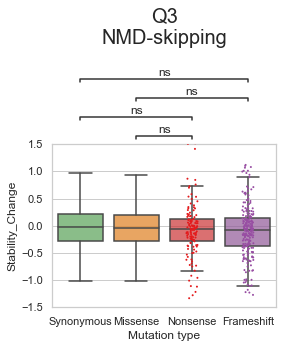

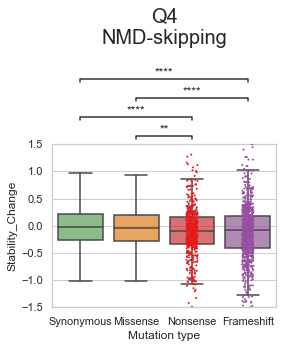

In [91]:
#Mutation type comparison by relative mutation position, NMD-skipping
df = cptac_df[cptac_df['Protein_position_relative']=='Q1']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']<0.25)|(df['Phenotype']=='stop_gained')&(df['nmd_score']<0.25)]
rel_mut_pos_plot2(df,'Q1\nNMD-skipping','Stability_Change',2,-1.5,1.5)

df = cptac_df[cptac_df['Protein_position_relative']=='Q2']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']<0.25)|(df['Phenotype']=='stop_gained')&(df['nmd_score']<0.25)]
rel_mut_pos_plot2(df,'Q2\nNMD-skipping','Stability_Change',2,-1.5,1.5)

df = cptac_df[cptac_df['Protein_position_relative']=='Q3']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']<0.25)|(df['Phenotype']=='stop_gained')&(df['nmd_score']<0.25)]
rel_mut_pos_plot2(df,'Q3\nNMD-skipping','Stability_Change',2,-1.5,1.5)

df = cptac_df[cptac_df['Protein_position_relative']=='Q4']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']<0.25)|(df['Phenotype']=='stop_gained')&(df['nmd_score']<0.25)]
rel_mut_pos_plot2(df,'Q4\nNMD-skipping','Stability_Change',2,-1.5,1.5)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

missense_variant v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.775e-06 U_stat=7.348e+06
synonymous_variant v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.399e-08 U_stat=2.585e+06
missense_variant v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.014e-07 U_stat=1.020e+07
synonymous_variant v.s. frameshift_variant: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.056e-09 U_stat=3.586e+06
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

missense_variant v.s. stop_gained: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.704e-10 U_stat

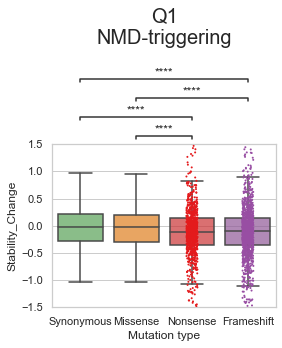

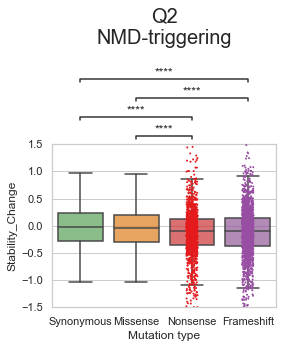

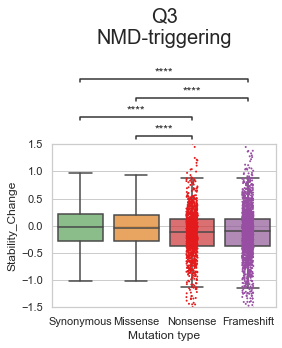

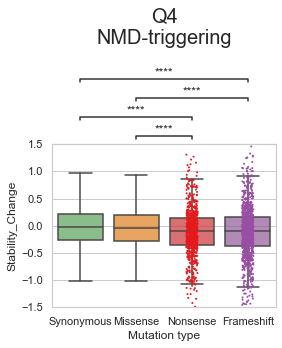

In [93]:
#Mutation type comparison by relative mutation position, NMD-triggering
df = cptac_df[cptac_df['Protein_position_relative']=='Q1']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']>0.52)|((df['Phenotype']=='stop_gained')&(df['nmd_score']>0.52))]
rel_mut_pos_plot2(df,'Q1\nNMD-triggering','Stability_Change',2,-1.5,1.5)

df = cptac_df[cptac_df['Protein_position_relative']=='Q2']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']>0.52)|((df['Phenotype']=='stop_gained')&(df['nmd_score']>0.52))]
rel_mut_pos_plot2(df,'Q2\nNMD-triggering','Stability_Change',2,-1.5,1.5)

df = cptac_df[cptac_df['Protein_position_relative']=='Q3']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']>0.52)|((df['Phenotype']=='stop_gained')&(df['nmd_score']>0.52))]
rel_mut_pos_plot2(df,'Q3\nNMD-triggering','Stability_Change',2,-1.5,1.5)

df = cptac_df[cptac_df['Protein_position_relative']=='Q4']
df = df[(df['Phenotype']=='missense_variant')|(df['Phenotype']=='synonymous_variant')|(df['Phenotype']=='frameshift_variant')&(df['nmd_score']>0.52)|((df['Phenotype']=='stop_gained')&(df['nmd_score']<0.52))]
rel_mut_pos_plot2(df,'Q4\nNMD-triggering','Stability_Change',2,-1.5,1.5)

## Figure S5: Relative mutation position in CCLE and CPTAC VAF>0.3

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.597e-15 U_stat=5.116e+08
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.540e-01 U_stat=4.796e+04
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.072e-01 U_stat=7.227e+04
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.094e-03 U_stat=2.594e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.665e-35 U_stat=1.870e+09
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.806e+06
Q1 v.s. Q3: 

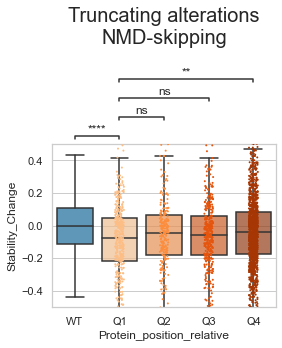

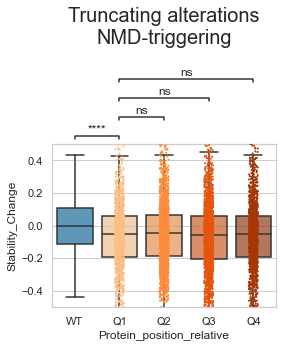

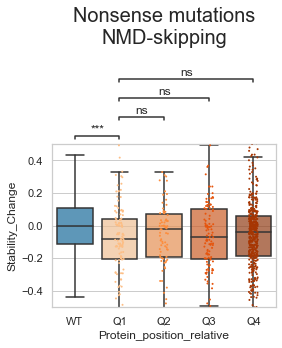

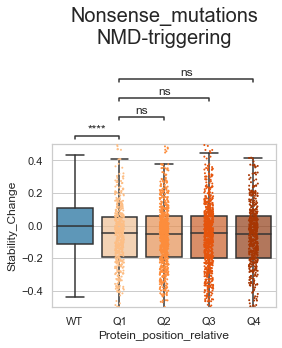

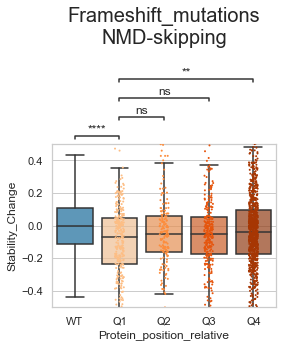

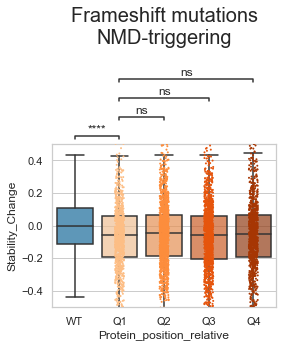

In [69]:
#Relative mutation position CCLE
df = ccle_df[(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']<0.25)|(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']<0.25)]
rel_mut_pos_plot (df,'Truncating alterations\nNMD-skipping','Stability_Change',2,-0.5,0.5)

df = ccle_df[(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']>0.52)|(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']>0.52)]
rel_mut_pos_plot (df,'Truncating alterations\nNMD-triggering','Stability_Change',2,-0.5,0.5)

df = ccle_df[(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']<0.25)]
rel_mut_pos_plot (df,'Nonsense mutations\nNMD-skipping','Stability_Change',2,-0.5,0.5)

df = ccle_df[(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='stop_gained')&(ccle_df['nmd_score']>0.52)]
rel_mut_pos_plot (df,'Nonsense_mutations\nNMD-triggering','Stability_Change',2,-0.5,0.5)

df = ccle_df[(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']<0.25)]
rel_mut_pos_plot (df,'Frameshift_mutations\nNMD-skipping','Stability_Change',2,-0.5,0.5)

df = ccle_df[(ccle_df['Phenotype']=='WT')|(ccle_df['Phenotype']=='frameshift_variant')&(ccle_df['nmd_score']>0.52)]
rel_mut_pos_plot (df,'Frameshift mutations\nNMD-triggering','Stability_Change',2,-0.5,0.5)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.342e-08 U_stat=2.653e+08
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.216e-02 U_stat=7.940e+02
Q1 v.s. Q3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.512e-02 U_stat=1.113e+03
Q1 v.s. Q4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.698e-02 U_stat=5.084e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Q1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.861e-16 U_stat=1.180e+09
Q1 v.s. Q2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.894e+04
Q1 v.s. Q3: 

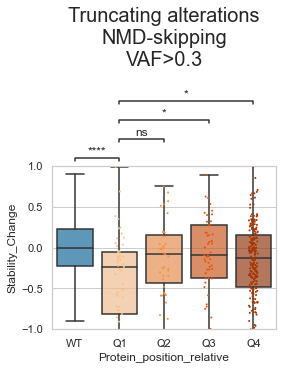

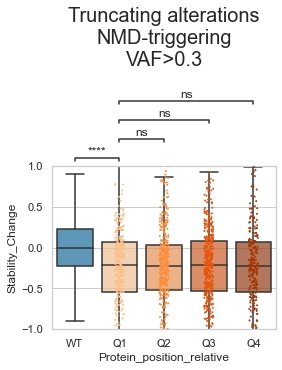

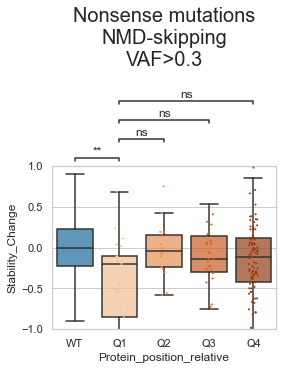

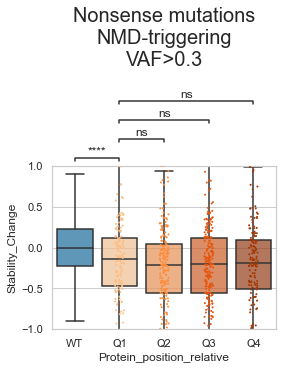

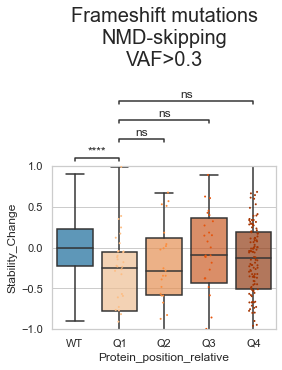

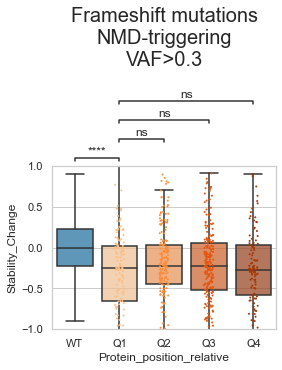

In [70]:
#Relative mutation position CPTAC VAF>0.3
df = cptac_df[(cptac_df['Phenotype']=='WT')|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25))|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))]
rel_mut_pos_plot (df,'Truncating alterations\nNMD-skipping\nVAF>0.3','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52))|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))]
rel_mut_pos_plot (df,'Truncating alterations\nNMD-triggering\nVAF>0.3','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']<0.25))]
rel_mut_pos_plot (df,'Nonsense mutations\nNMD-skipping\nVAF>0.3','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='stop_gained')&(cptac_df['nmd_score']>0.52))]
rel_mut_pos_plot (df,'Nonsense mutations\nNMD-triggering\nVAF>0.3','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']<0.25))]
rel_mut_pos_plot (df,'Frameshift mutations\nNMD-skipping\nVAF>0.3','Stability_Change',2,-1,1)

df = cptac_df[(cptac_df['Phenotype']=='WT')|((cptac_df['AF_cancer']>0.3)&(cptac_df['Phenotype']=='frameshift_variant')&(cptac_df['nmd_score']>0.52))]
rel_mut_pos_plot (df,'Frameshift mutations\nNMD-triggering\nVAF>0.3','Stability_Change',2,-1,1)